In [13]:
## Lifelines
import json

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal
from scipy.stats import sem
from itertools import groupby
import spacy
import copy

nlp = spacy.load("en_core_web_sm")

titles = ['Horror', 'Adventure', 'Drama', 'Biography', 'Action', 'Fantasy', 'SciFi', 'Animation']

Bigger than 300.. R_bpSmUrechdDZuAF
749
Bigger than 300.. R_bpSmUrechdDZuAF
437
Bigger than 300.. R_bpSmUrechdDZuAF
637
Bigger than 300.. R_bpSmUrechdDZuAF
515
Bigger than 300.. R_bpSmUrechdDZuAF
616
Bigger than 300.. R_bpSmUrechdDZuAF
476
Bigger than 300.. R_bpSmUrechdDZuAF
566
Bigger than 300.. R_bpSmUrechdDZuAF
723
Bigger than 300.. R_Dr8NtXeQ2WcuA7L
341
Bigger than 300.. R_Dr8NtXeQ2WcuA7L
317
Bigger than 300.. R_Dr8NtXeQ2WcuA7L
309
Bigger than 300.. R_qCtAFnNVzy3tj3P
446
Bigger than 300.. R_qCtAFnNVzy3tj3P
439
Bigger than 300.. R_1BXJjlHfdJhzN2W
332
Bigger than 300.. R_1BXJjlHfdJhzN2W
321
Bigger than 300.. R_1NlgJRLnrPZ3IDX
682
Bigger than 300.. R_1NlgJRLnrPZ3IDX
900
Bigger than 300.. R_1NlgJRLnrPZ3IDX
589
Bigger than 300.. R_1NlgJRLnrPZ3IDX
449
Bigger than 300.. R_1NlgJRLnrPZ3IDX
365
Bigger than 300.. R_1NlgJRLnrPZ3IDX
654
Bigger than 300.. R_1NlgJRLnrPZ3IDX
492
Bigger than 300.. R_2fxopL2E7wN6bV0
428
Bigger than 300.. R_246Oj0XNUz3WZno
306
Bigger than 300.. R_246Oj0XNUz3WZno
382


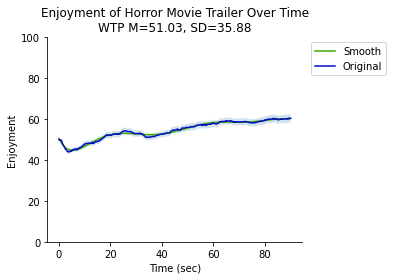

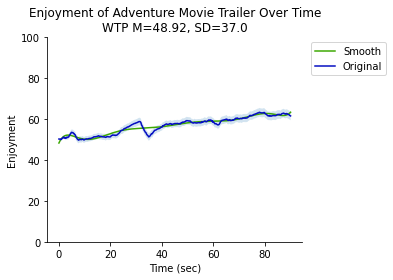

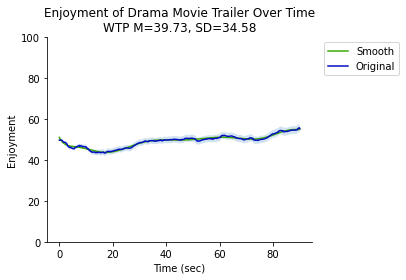

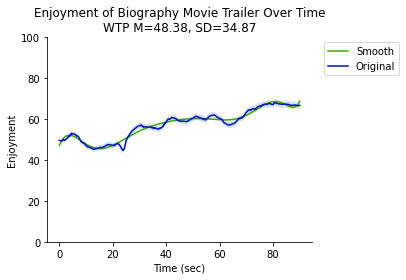

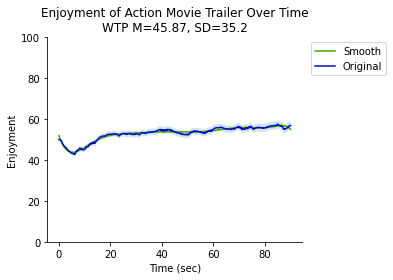

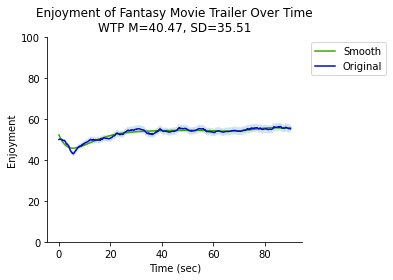

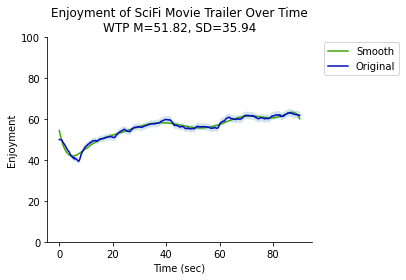

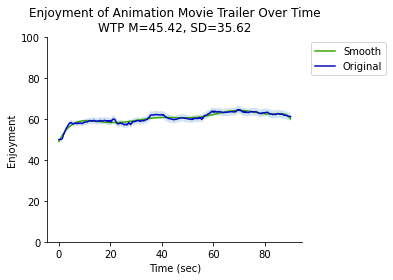

In [15]:

def plot_lines(ys, title, wtp_mean, wtp_std, mean=False):
    if mean:
        ys_mean = np.stack(ys).mean(axis=0)
        ys_sem = sem(np.stack(ys), axis=0)
    else:
        ys_mean = ys

    xs = np.linspace(0, 90, num=900)

    plt.figure()
    poly = np.polyfit(xs, ys_mean, 10)
    poly_y = np.poly1d(poly)(xs)
    plt.plot(xs, poly_y, color="#3da803", label="Smooth")
    plt.plot(xs, ys_mean, color="#040dc2", label="Original")

    if mean:
        plt.fill_between(xs, ys_mean - ys_sem, ys_mean + ys_sem, alpha=0.2)
    plt.ylabel("Enjoyment")
    plt.xlabel("Time (sec)")
    plt.title("Enjoyment of {} Movie Trailer Over Time\nWTP M={}, SD={}".format(title, str(wtp_mean), str(wtp_std)))

    plt.legend(bbox_to_anchor=(1.35, 1.0))
    plt.tight_layout()

    ax = plt.gca()
    ax.set_ylim([0, 100])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show()

    #plt.savefig("../plots/lifeline_{}.png".format(title), dpi=1000)

data = pd.read_csv('./data/data_prolific.csv')

## Performquad(np.poly1d(np.polyfit(xs, ys_mean, 10)), 0, 100) Exclusions
data = data.drop(data[data.Finished != 'True'].index)

## All passed at least one of the two attention and comprehension checks
## Drop low connections
#data = data.drop(data[data.ResponseId == 'R_10ovXcMfOnkIZYm'].index) # ON MTURK DATA

lengths = []

def listify(row):
    row = str(row).split(',')
    row = [float(y) for y in row]

    return row

for title in titles:
    data.loc[:, '{}Enjoyment'.format(title)] = data.loc[:, '{}Enjoyment'.format(title)].apply(listify, args=())
    estr = '4' if title not in ['Action', 'Adventure'] else '1'

## Remove data with too few or many points, and exclude those who have the same enjoyments for more than 30 seconds
rms = []
for index, row in data.iterrows():
    for title in titles:
        if abs(len(row['{}Enjoyment'.format(title)]) - 900) > 300:
            print("Low data qual {}".format(row['ResponseId']))
            print(len(row['{}Enjoyment'.format(title)]))
            rms.append(row['ResponseId'])

        if max([sum(1 for i in g) for k,g in groupby(row['{}Enjoyment'.format(title)])]) > 300:
            print("Bigger than 300.. {}".format(row['ResponseId']))
            print(max([sum(1 for i in g) for k,g in groupby(row['{}Enjoyment'.format(title)])]))
            rms.append(row['ResponseId'])



rms = list(dict.fromkeys(rms))
data = data[~data['ResponseId'].isin(rms)]
print(rms)
print(len(rms))

def resample_time(row):
    return signal.resample(row, 900)

##  Resample the data to be 900 ms, and plot the graphs
for title in titles:
    data.loc[:, '{}Enjoyment'.format(title)] = data.loc[:, '{}Enjoyment'.format(title)].apply(resample_time)
    estr = '4' if title not in ['Action', 'Adventure'] else '1'
    plot_lines(data.loc[:, '{}Enjoyment'.format(title)], title='{}'.format(title), wtp_mean=round(data['{}_willing_{}'.format(title.lower(), estr)].astype(int).mean(), 2), wtp_std=round(data['{}_willing_{}'.format(title.lower(), estr)].astype(int).std(), 2), mean=True)


In [ ]:
import copy

# Calculate metrics for predicting enjoyments...

xs = np.linspace(0, 90, num=900)

# Number of Peaks
def get_num_peaks(row):
    poly = np.polyfit(xs, row, 10)
    poly_y = np.poly1d(poly)(xs)

    peaks, _ = signal.find_peaks(poly_y)

    #plot_lines(row, "asd", 0, 0)
    return len(peaks)

# Number of Valleys
def get_num_valleys(row):
    poly = np.polyfit(xs, row, 10)
    poly_y = np.poly1d(poly)(xs)

    # Find peaks of negative signal ---
    peaks, _ = signal.find_peaks(-poly_y)

    #plot_lines(row, "asd", 0, 0)
    return len(peaks)

# Number of Extrema
def get_num_extrema(row):
    return get_num_peaks(row) + get_num_valleys(row)

def get_first_derivative(row):
    poly = np.polyfit(xs, row, 10)
    return json.dumps(list(np.polyder(poly)))

def get_poly(row):
    #plot_lines(row, "asd", 0, 0)
    return json.dumps(list(np.polyfit(xs, row, 10)))

## Save the polynomials for R
for title in titles:
    data[title + '_first_derivative'] = data.loc[:, '{}Enjoyment'.format(title)].apply(get_first_derivative)
    data[title + '_equation'] = data.loc[:, '{}Enjoyment'.format(title)].apply(get_poly)
    data[title + '_number_peaks'] = data.loc[:, '{}Enjoyment'.format(title)].apply(get_num_peaks)
    data[title + '_number_valleys'] = data.loc[:, '{}Enjoyment'.format(title)].apply(get_num_valleys)
    data[title + '_number_extrema'] = data.loc[:, '{}Enjoyment'.format(title)].apply(get_num_extrema)


data.to_csv('./data/lifelines_cleaned_sentence.csv')

In [9]:
#    Let's convert the data to long format, so that we have a row for every genre
#    Input: dataframe with number of rows = n_subjects
#    Output: dataframe with number of rows = n_subjects * n_genres (=8)
data = pd.read_csv('./data/lifelines_w_features.csv')

df = None
count = 1

# Split the columns, based on name
for title in titles:
    a = data.filter(regex=(title))
    b = data.filter(regex=(title.lower()))

    acols = [c for c in a.columns][4:]
    bcols = [c for c in b.columns][5:]

    a = a[acols]
    b = b[bcols]

    X = pd.concat([a, b], axis=1)

    old_colnames = list(X.columns)
    new_colnames = {}

    for old in old_colnames:
        new_colnames[old] = old.lower().split(title.lower() + "_")[1]

        if 'willing' in new_colnames[old]:
            new_colnames[old] = new_colnames[old][:-2]

    X = X.rename(columns = new_colnames)
    X['genre'] = title

    X['subject'] = [c for c in range(1, data.shape[0] + 1)]
    X['movie_choice'] = data['movie_choice']
    count += 1


    if df is None:
        df = copy.deepcopy(X)
    else:
        df = pd.concat([df, X], axis=0)


df = df.sort_values(by=['subject', 'genre'])

def get_token(row):
    return [token.pos_ for token in nlp(row)][0]

def get_tokens_sentences(row):
    return [token.pos_ for token in nlp(row)]

df.loc[:, 'word_tag'] = df.loc[:, 'word'].apply(get_token)

df.to_csv('./data/data.csv')

In [12]:
nlp("cat")

cat